In [1]:
import torch 
print('CUDA available:', torch.cuda.is_available())


CUDA available: True


In [3]:
from totalsegmentator.python_api import totalsegmentator
if __name__ == "__main__":
    input_file = "example_ct.nii.gz"
    output_file = "segmentations"

    out_segmentation = totalsegmentator(
        input=input_file,
        output=output_file,
        fast=False, 
        preview = False,
        task="total", 
        ml=True, 
        verbose=True
    )

    print(f"Solutions: {output_file}")

Using Device: cuda:0

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

tmp_dir: /tmp/nnunet_tmp_p2ab0v82
Resampling...
  from shape (122, 101, 112) to shape (244, 202, 224)
  Resampled in 2.88s
Predicting part 1 of 5 ...
There are 1 cases in the source folder
I am processing 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 1 cases that I would like to predict

Predicting s01:
perform_everything_on_device: True


100%|██████████| 12/12 [00:01<00:00,  9.92it/s]


sending off prediction to background worker for resampling and export
done with s01
Predicting part 2 of 5 ...
There are 1 cases in the source folder
I am processing 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 1 cases that I would like to predict

Predicting s01:
perform_everything_on_device: True


100%|██████████| 12/12 [00:00<00:00, 62.81it/s]


sending off prediction to background worker for resampling and export
done with s01
Predicting part 3 of 5 ...
There are 1 cases in the source folder
I am processing 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 1 cases that I would like to predict

Predicting s01:
perform_everything_on_device: True


100%|██████████| 12/12 [00:00<00:00, 63.83it/s]


sending off prediction to background worker for resampling and export
done with s01
Predicting part 4 of 5 ...
There are 1 cases in the source folder
I am processing 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 1 cases that I would like to predict

Predicting s01:
perform_everything_on_device: True


100%|██████████| 12/12 [00:00<00:00, 64.62it/s]


sending off prediction to background worker for resampling and export
done with s01
Predicting part 5 of 5 ...
There are 1 cases in the source folder
I am processing 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 1 cases that I would like to predict

Predicting s01:
perform_everything_on_device: True


100%|██████████| 12/12 [00:00<00:00, 62.67it/s]


sending off prediction to background worker for resampling and export
done with s01
  Predicted in 139.74s
Resampling...
  back to original shape: (122, 101, 112)
Undoing canonical...
Saving segmentations...
  Saved in 0.08s
Solutions: segmentations


In [ ]:
from skimage.morphology import binary_erosion, disk, ball
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline

erosion_on = 1
k_means_on = 1
segmentation_mask = 1

seg_sitk = sitk.ReadImage('segmentations.nii')
ct_sitk = sitk.ReadImage('example_ct.nii')
ct_intensities = sitk.GetArrayFromImage(ct_sitk)

voxel_spacing = seg_sitk.GetSpacing()  # (x, y, z)
origin = seg_sitk.GetOrigin()
direction = seg_sitk.GetDirection()
segmentation = sitk.GetArrayFromImage(seg_sitk)

if segmentation_mask:
    segmentation_masked_organ = (segmentation > 5) & (segmentation < 7)  # bool mask
else:
    segmentation_masked_organ = segmentation > 0

if erosion_on:
    mask3d_eroded = binary_erosion(segmentation_masked_organ, footprint=ball(1))
else:
    mask3d_eroded = segmentation_masked_organ

ct_masked = np.where(mask3d_eroded, ct_intensities , 0)

if k_means_on:
    k = 10
    mask = mask3d_eroded.astype(bool)

    # --- features ---
    coords = np.argwhere(mask).astype(np.float32)      # (N,3)
    intens = ct_intensities[mask].reshape(-1, 1).astype(np.float32)  # (N,1)

    # normalize
    coords = (coords - coords.mean(0, keepdims=True)) / (coords.std(0, keepdims=True) + 1e-8)
    intens = (intens - intens.mean(0, keepdims=True)) / (intens.std(0, keepdims=True) + 1e-8)

    # combine features
    X = np.hstack([intens, 2.0*coords])

    # --- kmeans ---
    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=0)
    labels = kmeans.fit_predict(X)     # 0..k-1

    clustered = np.zeros(mask.shape, dtype=np.uint16)
    clustered[mask] = labels + 1       # 1..k

    mask3d_eroded = clustered

else:
    mask3d_eroded = mask3d_eroded

warped_sitk = sitk.GetImageFromArray(mask3d_eroded.astype(np.uint16))
warped_sitk.SetSpacing(voxel_spacing)
warped_sitk.SetOrigin(origin)
warped_sitk.SetDirection(direction)
orienter = sitk.DICOMOrientImageFilter()
orienter.SetDesiredCoordinateOrientation('RAS')
warped_sitk = orienter.Execute(warped_sitk)
sitk.WriteImage(warped_sitk, "erosioned_img_kmeans.nii.gz")
print("image saved!")





image saved!


/tmp/ipykernel_2089188/3504375611.py:27: FutureWarning: `binary_erosion` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.erosion` instead. Note the pixel shift by 1 for even-sized footprints (see docstring notes).
  mask3d_eroded = binary_erosion(segmentation_masked_organ, footprint=ball(1))


In [9]:
print(segmentation_masked_organ.shape)
print(ct_intensities.shape)

(112, 101, 122)
(112, 101, 122)


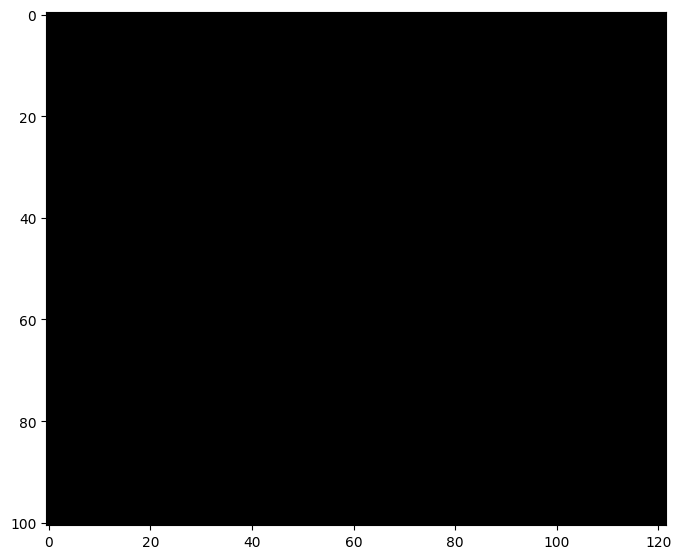

[  0   1   2   3   4   5   6   7   8   9  10  11  13  14  18  19  20  21
  22  25  26  27  28  29  30  31  32  33  52  63  64  65  66  67  68  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  98  99 100 101
 102 103 110 111 112 113 114 115 117]
['1: spleen', '2: kidney_right', '3: kidney_left', '4: gallbladder', '5: liver', '6: stomach', '7: pancreas', '8: adrenal_gland_right', '9: adrenal_gland_left', '10: lung_upper_lobe_left', '11: lung_lower_lobe_left', '13: lung_middle_lobe_right', '14: lung_lower_lobe_right', '18: small_bowel', '19: duodenum', '20: colon', '21: urinary_bladder', '22: prostate', '25: sacrum', '26: vertebrae_S1', '27: vertebrae_L5', '28: vertebrae_L4', '29: vertebrae_L3', '30: vertebrae_L2', '31: vertebrae_L1', '32: vertebrae_T12', '33: vertebrae_T11', '52: aorta', '63: inferior_vena_cava', '64: portal_vein_and_splenic_vein', '65: iliac_artery_left', '66: iliac_artery_right', '67: iliac_vena_left', '68: iliac_vena_right', '75: femur_left', '76: femur_ri

In [37]:
from totalsegmentator.map_to_binary import class_map

plt.figure(figsize=(8, 8))
plt.imshow(mask3d_eroded[mask3d_eroded.shape[0]//2], cmap='gray')
plt.show()
print(np.unique(segmentation))

print([f"{i}: {class_map['total'][i]}" for i in np.unique(segmentation) if int(i) in class_map["total"]])